# 1) Exploratory Analysis

The data was loaded from json as a pandas dataframe and aggregated per 15 minute intervals. I resampled the data at several periods: 6 hours, daily, and weekly. Longer periods were not relevant since the data only spanned four months. From Figure 1 & 2, cycles in the 6 hour data are clearly seen, however their size is obscured by cycles occuring during the week, and a slow moving, possibly seasonal cycle.

After subtracting the slow moving weekly cycle from the daily aggregated data, Figure 3 shows that the logins have a peak on Saturday and Sunday, crashing on Monday, and not recovering to above average logins until Thursday.

I performed a similar operation to find intra-day cycles. After subtracting the daily and weekly cycles from the original data, I took the average value of each fifteen minute interval aggregated over the days in the collection period. The resulting graph is shown in figure 3 where logins compared to the average is plotted vs time. A positive number in this graph is more logins than average while a negative number is less logins than average. 

The graph clearly demonstrates a major dip around 7:30am and another smaller dip around 5pm. Peaks in logins are centered around noon and midnight.

In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
#Load in the JSON file as a string
user_file = 'ultimate_data_challenge.json'
logins_file = 'logins.json'

df_logins = pd.read_json(logins_file,typ='frame')
    
with open(user_file) as json_file:
    json_string = json.load(json_file)
    df_users = json_normalize(json_string)

In [3]:
df_logins['logins'] = 1
ts = df_logins.set_index('login_time')
ts_resampled = ts.resample('15T').count()
print('The data set runs from',
      ts.index[0],'to',
      ts.index[-1])
ts_avg = float(ts_resampled.mean())
ts_shiftly = ts_resampled.resample('6H').mean()
ts_daily = ts_resampled.resample('D').mean()
ts_weekly = ts_resampled.resample('W').mean()
ts_monthly = ts_resampled.resample('M').mean()
print('The average number of logins per 15 minute period is',round(ts_avg,1))
max_logins = int(np.max(ts_resampled))
min_logins = int(np.min(ts_resampled))
print('The maximum number of logins per 15 minute period is',max_logins)
print('The minimum number of logins per 15 minute period is',min_logins)

The data set runs from 1970-01-01 20:13:18 to 1970-04-13 18:54:23
The average number of logins per 15 minute period is 9.5
The maximum number of logins per 15 minute period is 73
The minimum number of logins per 15 minute period is 0


In [4]:
def downsample_datelabels(series,time_string):
    #generate labels
    ticklabels = []
    for date in series.index:
        if date.strftime(time_string) in ticklabels:
            ticklabels.append('')
        else:
            ticklabels.append(date.strftime(time_string))
    return ticklabels

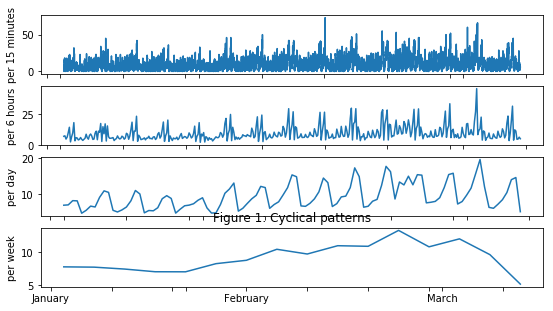

In [5]:
fig = plt.figure(figsize = [9,5])
ax1 = plt.subplot(4,1,1)
ax1.plot(ts_resampled)
ax1.set_xticklabels([])
ax1.set_ylabel('per 15 minutes')

ax2 = plt.subplot(4,1,2)
ax2.plot(ts_shiftly)
ax2.set_xticklabels([])
ax2.set_ylabel('per 6 hours')

ax3 = plt.subplot(4,1,3)
ax3.plot(ts_daily)
ax3.set_xticklabels([])
ax3.set_ylabel('per day')

ax4 = plt.subplot(4,1,4)
ax4.plot(ts_weekly)
x_ticklabels = downsample_datelabels(ts_weekly,'%B')
ax4.set_xticklabels(x_ticklabels)
ax4.set_ylabel('per week')

plt.title('Figure 1: Cyclical patterns')
plt.show()

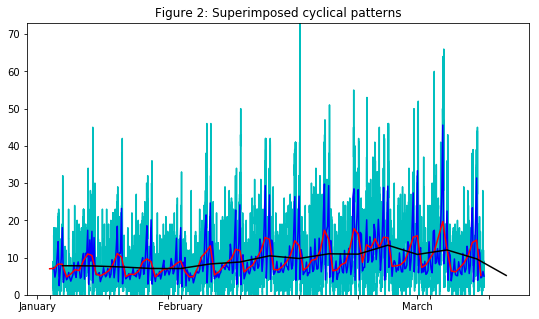

In [6]:
fig = plt.figure(figsize = [9,5])
ax1 = fig.add_subplot(1,1,1)
ax1.plot(ts_resampled,color = 'c')
ax1.plot(ts_shiftly,color = 'b')
ax1.plot(ts_daily,color = 'r')
ax1.plot(ts_weekly,color = 'k')
ax1.set_xticklabels(x_ticklabels)
ax1.set_ylim(min_logins,max_logins)
plt.title('Figure 2: Superimposed cyclical patterns')
plt.show()

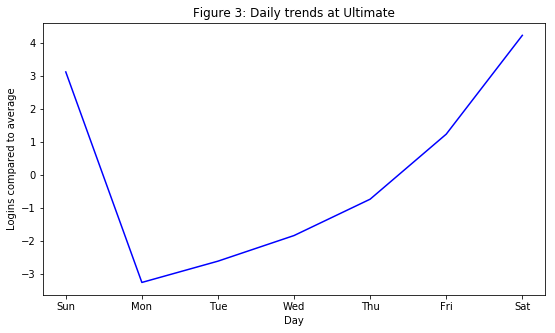

In [7]:
ts_daily_trends = ts_daily - ts_weekly.resample('1D').interpolate()
index = ts_daily_trends.index
avg_logins = ts_daily_trends.groupby([index.strftime('%w')]).mean()
fig = plt.figure(figsize = [9,5])
ax1 = fig.add_subplot(1,1,1)
ax1.plot(avg_logins,color = 'b')
xticklabels = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
ax1.set_xticklabels(xticklabels)
plt.xlabel('Day')
plt.ylabel('Logins compared to average')
plt.title('Figure 3: Daily trends at Ultimate')
plt.show()

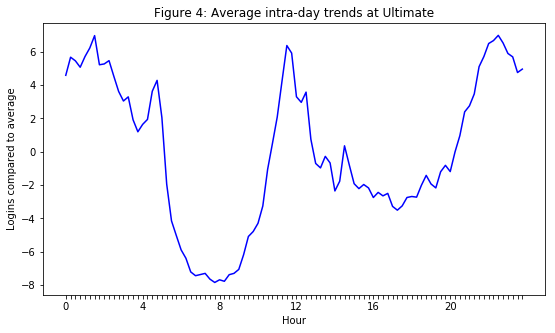

In [8]:
ts_intraday_trends = ts_resampled - ts_daily.resample('15T').interpolate()
index = ts_intraday_trends.index
avg_logins = ts_intraday_trends.groupby([index.strftime('%H:%M')]).mean()
fig = plt.figure(figsize = [9,5])
ax1 = fig.add_subplot(1,1,1)
ax1.plot(avg_logins,color = 'b')
#generate tick labels
xticklabels = []
for time_string in avg_logins.index:
    if int(time_string[-2:])==0:
        if int(time_string[:2])%4 == 0:
            xticklabels.append(int(time_string[:2]))
        else:
            xticklabels.append('')
    else:
        xticklabels.append('')
ax1.set_xticklabels(xticklabels)
plt.xlabel('Hour')
plt.ylabel('Logins compared to average')
plt.title('Figure 4: Average intra-day trends at Ultimate')
plt.show()

# 2) Experiment and Metric Design

Since drivers stay exclusive to one city or the other, the concern in this scenario is that driver partners who would like to be driving more choose not to because of the toll. This decreases the revenue of Ultimate, the driver, and creates longer wait times for customers, who may switch over to using Lultimate instead. However, if the increased cost of toll reimbursement exceeds the increased revenue by a fair margin, then the other positive outcomes would not be worth it. Therefore a good metric for success of the experiment would be revenue change per dollar spent on tolls and decreased wait times per dollar spent on tolls. 

A controlled experiment to measure these outcomes would be to try reimburse tolls for a full two weeks, with enough warning (two weeks) so that drivers would make rational decisions about their schedule and take necessary actions to maximize their drive time. Revenue and wait times in the two cities can be compared in a two week period before and after the warning period.

A simple t-test would be an appropriate way of comparing the two groups of data to find if a difference in mean revenue or mean wait time existed in the no-reimbursement vs reimbursement data sets. These tests could be broken down for different days of the week or hours of the day to avoid normal daily cycles from washing out an effect. However, if the number of different time periods compared is increased, the threshold for significance must increase as well. For example, if just one t-test is performed for the mean revenue, a p-value of less than 0.05 would be significant, whereas if the tests were performed for each day of the week separately, than the p-value would have to be less than 0.05/7 = 0.007. 

Another possibility is that the revenue of each driver individually in both scenarios can be compared in a paired t-test as well as the wait time of individual users in both reimbursed and un-reimbursed scenarios. This may be more accurate, if the data is available, though the same caveats on p-values apply.

The reccommendations I would make from the data would be to enact the program or not based on the effect size and significance. A significant positive change in revenue paired with a significant negative change in wait time would reccommend the program. A significant positive change in revenue with a significant positive change in wait time would reccommend the program only if the effect of the wait time was very small and the effect of the revenue was at lest moderate. A significant negative change in revenue with a significant negative change in wait time would again only reccommend the program is the effect of wait time was large and the effect revenue was small. Finally, a significant negative change in revenue with a significant positive change in wait time would reccommend against the program.

# 3) Predictive Modeling

The data was cleaned by removing date columns, since the signup date is explicitly selected and therefore biased and the 'last_trip_date' is highly correlated with what we are trying to predict. Categorical variables such as phone and city were changed from strings to categories, and an 'other' phone category was created to store NaN in the original data.

Numerical columns by and large were clean, however average ratings of both drivers and users had some missing values, which were filled in with the average value for the column. Since the number of missing values was small, and the range of ratings was fairly tight, I don't believe how this data is imputed will matter much.

An 'is retained' variable was created and set to 1 for all users with a 'last login date' within 30 days of the latest date in the dataset. About 38% of the users were retained. Finally, the numerical data was centered around the mean and normalized by the standard deviation, and categorical data was converted to dummy variables.

The model chosen was logistic regression as this is generally a good first choice for a binary classification problem and outputs highly interpretable models. Support Vector Machine (SVM) would also be a possibility, and would be worth exploring if logistic regression fails to fit the data sufficiently. K-nearest-neighbors would probably work, but can be incredibly slow as the data becomes more complex.

Using default parameters, the model correctly predicts retention on a held-out test set about 70% of the time. Since a little over a third of the users were retained, the data is slightly unbalanced, and therefore precision-recall metrics are more appropriate than accuracy.

Of the users the model labels at 'retained', 59% of those are in fact retained. Meanwhile the model captures 67% of all retained users. This means that there is definitely improvements possible, and trying other algorithms in the future may be fruitful, since precursory experimentation with non-default parameters didn't change the outcomes of the regression model by more the a few percentage points. However, the model is significantly better than guessing, as clearly evidenced by the ROC curve in figure 5, and so it is worth trying to glean insights from the model.

An advantage to logistic regression, is that the coefficients it outputs can be converted easily to an odds ratio, meaning the probability that a user is retained over the probability that a user is not retained. A ratio less than one points to a variable that hurts retention, and a ratio greater than one points to a variable that helps retention. 

Two variables that lead to a user being half as likely to be retained are being in Astapor and using an Android phone, while a user being in King's Landing more than doubled the odds of the user being retained. Using an iphone, being an Ultimate Black user and taking more trips in the first thirty days also correlated with increased retention, but to a lesser extent.

In [9]:
df_users['phone'] = df_users['phone'].fillna('Other')
avg_rating_by_driver = df_users['avg_rating_by_driver'].mean()
df_users['avg_rating_by_driver'] = df_users['avg_rating_by_driver'].fillna(avg_rating_by_driver)
avg_rating_of_driver = df_users['avg_rating_of_driver'].mean()
df_users['avg_rating_of_driver'] = df_users['avg_rating_of_driver'].fillna(avg_rating_of_driver)

In [10]:
#Turn last_trip_date and signup_date into datetimes
df_users['last_trip_date'] = pd.to_datetime(df_users['last_trip_date'],format = "%Y-%m-%d")
df_users['signup_date'] = pd.to_datetime(df_users['signup_date'],format = "%Y-%m-%d")

#Turn city and phone into factor variables
df_users["phone"] = pd.Categorical(df_users.phone, 
                                   categories=df_users.phone.unique(),
                                   ordered=False)

df_users["city"] = pd.Categorical(df_users.city, 
                                   categories=df_users.city.unique(),
                                   ordered=False)

In [11]:
df_users = df_users.sort_values(['last_trip_date','signup_date']).reset_index(drop = True)
pull_date = max(df_users.last_trip_date)
df_users['is_retained'] = pull_date - df_users.last_trip_date <= timedelta(days=30) 

In [12]:
disc_var = ['phone','city','ultimate_black_user']
cont_var = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']
date_var = ['last_trip_date','signup_date']
target_var = ['is_retained']
df_users_processed = pd.get_dummies(df_users.loc[:,disc_var],prefix=disc_var,columns=disc_var,dummy_na=False)
disc_var = list(df_users_processed.columns)

for var in cont_var:
    mean = df_users[var].mean()
    stdev = df_users[var].std()
    df_users_processed[var] = (df_users[var] - mean)/stdev

In [13]:
feature_array = np.array(df_users_processed.loc[:,disc_var+cont_var])
feature_names = disc_var+cont_var
target_array = np.array(df_users.is_retained)

#Split into test/train
n_obs = feature_array.shape[0]
n_train = round(0.67*n_obs)
shuffle_index = np.random.choice(range(n_obs), size = n_obs, replace = False)
train_index = shuffle_index[:n_train]
test_index = shuffle_index[n_train:]

#Create X and y arrays
feature_array_train = feature_array[train_index,:]
feature_array_test = feature_array[test_index,:]

target_array_train = target_array[train_index]
target_array_test = target_array[test_index]

In [14]:
fraction_retained = target_array.sum()/len(target_array)
print('The fraction of retained users is:', round(fraction_retained,2))

The fraction of retained users is: 0.38


In [15]:
#Train model with default parameters
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(solver = 'liblinear',
                           class_weight = 'balanced',
                           C = 1,
                           penalty = 'l2'
                          )

model.fit(feature_array_train,
          target_array_train)

target_array_predict = model.predict(feature_array_test)

print(classification_report(target_array_test,
                            target_array_predict,
                            target_names = ['Not Retained','Retained']))

              precision    recall  f1-score   support

Not Retained       0.79      0.72      0.75     10321
    Retained       0.59      0.67      0.63      6179

   micro avg       0.70      0.70      0.70     16500
   macro avg       0.69      0.70      0.69     16500
weighted avg       0.71      0.70      0.71     16500



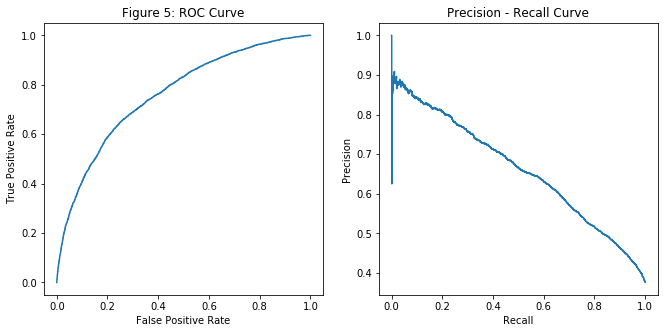

In [17]:
from sklearn.metrics import precision_recall_curve, roc_curve

target_array_probs = model.predict_proba(feature_array_test)[:,1]
precision, recall,thresholds = precision_recall_curve(target_array_test,target_array_probs)
fpr, tpr, thresholds = roc_curve(target_array_test, target_array_probs)

fig = plt.figure(figsize = [11,5])
ax1 = plt.subplot(1,2,1)
ax1.plot(fpr,tpr)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Figure 5: ROC Curve')

ax2 = plt.subplot(1,2,2)
ax2.plot(recall,precision)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision - Recall Curve')
plt.show()

In [18]:
coef_rank = np.argsort(model.coef_[0,:])
for coef in coef_rank:
    print(feature_names[coef],":",np.exp(model.coef_[0,coef]),'\n')

city_Astapor : 0.46813991720011455 

phone_Android : 0.5736280475275398 

ultimate_black_user_False : 0.6457386001427903 

city_Winterfell : 0.796760407408817 

avg_dist : 0.8262589538662128 

avg_rating_by_driver : 0.9346990448546355 

avg_rating_of_driver : 0.970018038745166 

avg_surge : 0.9706946942086795 

weekday_pct : 0.982589347340025 

phone_Other : 1.0213838443571415 

surge_pct : 1.0647275045953661 

ultimate_black_user_True : 1.5292981822394704 

trips_in_first_30_days : 1.5846275949179254 

phone_iPhone : 1.685503109418813 

city_King's Landing : 2.6475581112425317 

